In [1]:
from utils import propose_region, bet_unet
from model import load_model, unet, aunet
from tqdm import tqdm

import numpy as np
import nibabel as nib

import cv2
import os
import time

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Py

In [2]:
def detect_file(filename, model, unet):
    data = nib.load(filename)
    mask = nib.load(filename)
    mask_roi = nib.load(filename)

    width, height, frame_num = data.shape
    matrix = data.get_data()
    bet_matrix = np.uint8(bet_unet(matrix, unet))

    start = time.time()
    for i in tqdm(range(frame_num), desc='Detect in {}'.format(os.path.basename(filename))):
        img = matrix[:, :, i]
        bet = bet_matrix[:, :, i]
        selected, mask_ROI = detect(img, model, bet)
        mask.get_data()[:, :, i] = selected
        mask_roi.get_data()[:, :, i] = mask_ROI
    end = time.time()

    print('Using time {}s'.format(end - start))
    return mask, mask_roi


def detect(img, model, bet, pad=10, is_debug=False):
    width, height = img.shape
    mask_ROI = propose_region(img, is_debug) & bet
    num, labels, stats, centroid = cv2.connectedComponentsWithStats(
        mask_ROI, connectivity=8)
    selected = np.zeros_like(img)
    for i, stat, center in zip(range(num), stats, centroid):
        if is_debug:
            print(i, stat, center)
        x, y, w, h, area = stat
        # remove background
        if x == 0 and y == 0:
            continue
        cx, cy = np.uint8(center)
        # crop a slice around pickle
        # valid bounder
        if cx - pad < 0 or cx + pad > height or cy - pad < 0 or cy + pad > width:
            continue
        if is_debug:
            print('label:{}, center:({},{})'.format(i, cx, cy))
        slice_img = img[cy - pad: cy + pad, cx - pad: cx + pad]
        slice_img = slice_img[:, :, np.newaxis]
        slice_img = np.expand_dims(slice_img, axis=0)
        res = model.predict(slice_img)
        if np.argmax(res) == 1:
            selected[labels == i] = np.max(res)
            if is_debug:
                print('label:{}, center:({},{})'.format(i, cx, cy))
    return selected, mask_ROI

路径定义，数据、模型与结果在example文件夹中

In [3]:
data_root = 'example/data'
model_path = 'example/model'
result_path = 'example/result'
mask_path = 'example/mask'

# 单张图片检测

In [4]:
data_filename = '0507_90day50u_20190812_mouse51SWI.nii'
data_path = os.path.join(data_root, data_filename)

result_filename = '{}_detect.nii'.format(data_filename.split('/')[-1].split('.')[-2])

result_nii = os.path.join(result_path, result_filename)

model_name = 'CNN_p10_e2000.h5'
unet_path = os.path.join(model_path, 'unet_BET2.hdf5')
clf_path = os.path.join(model_path, model_name)
bet_net = unet(pretrained_weights=unet_path)
model = load_model(clf_path)

mask, mask_roi = detect_file(data_path, model, bet_net)

nib.save(mask, result_nii)
nib.save(mask_roi, 'roi.nii')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Detect in 0507_90day50u_20190812_mouse51SWI.nii: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.14it/s]


Using time 2.2896831035614014s


# 多张图片检测

In [5]:
model_name = 'CNN_p10_e2000.h5'
clf_path = os.path.join(model_path, model_name)
model = load_model(clf_path)

input_path = os.path.join(data_root, './')

method = ['bet', 'heatmap', 'unet'] 分别对应形态学、Heatmap和Unet三种检测方法

In [6]:
method = 'aunet'
print('Using {} for detection...'.format(method))
if method == 'bet':
    method_path = os.path.join(model_path, 'unet_BET2.hdf5')
    from detect import detect_file
    method_net = unet(pretrained_weights=method_path)
elif method == 'heatmap':
    method_path = os.path.join(model_path, 'unet_pm25_yuzq.hdf5')
    from detect_by_heatmap import detect_file
    method_net = unet(pretrained_weights=method_path)
elif method == 'unet':
    method_path = os.path.join(model_path, 'unet_pm25_yuzq.hdf5')
    from detect_by_unet import detect_file
    method_net = unet(pretrained_weights=method_path)
elif method == 'aunet':
    method_path = os.path.join(model_path, 'unet_attention_300_1e4_fl_25.hdf5')
    from detect_by_unet import detect_file
    method_net = unet(pretrained_weights=method_path)

Using aunet for detection...


In [7]:
method_net.layers

In [8]:
NII_fileList = []
for dirName, subdirList, fileList in os.walk(input_path):
    for filename in fileList:
        if ".nii" in filename.lower():
            # print filename
            NII_fileList.append(os.path.join(dirName, filename))

In [9]:
for file in tqdm(NII_fileList, desc='Detect in {}'.format(os.path.abspath(input_path))):
    filename = os.path.basename(file)
    output_name = '{}_detect_by_{}.nii'.format(filename.split('.')[-2], method)
    output_path = os.path.join(result_path, output_name)
    mask, _ = detect_file(file, model, method_net)
    nib.save(mask, output_path)

Detect in 0507_90day50u_20190812_mouse51SWI.nii: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 652.33it/s]


Using time 0.04895663261413574s


Detect in 0507_90day50u_20190812_mouse52SWI.nii: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 588.40it/s]


Using time 0.05596733093261719s


Detect in 0507_90day50u_20190812_mouse53SWI.nii: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 638.64it/s]


Using time 0.049971580505371094s


Detect in 0507_90day50u_20190812_mouse99SWI.nii: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 517.51it/s]


Using time 0.06496572494506836s


Detect in F:\GitHub\DICOM\example\data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.52s/it]


# 检测结果可视化

In [10]:
from matplotlib import pyplot as plt

检测方法
result_method = ['bet', 'heatmap', 'unet']

In [11]:
result_method = 'aunet'

测试文件
data_filename = ['0507_90day50u_20190812_mouse51SWI.nii', '0507_90day50u_20190812_mouse52SWI.nii']
标记文件
mask_filename = ['51.nii', '52.nii']

In [12]:
data_filename = '0507_90day50u_20190812_mouse51SWI.nii'
data_path = os.path.join(data_root, data_filename)
mask_filename = os.path.join(mask_path, '51.nii')
result_filename = os.path.join(result_path, '{}_detect_by_{}.nii'.format(data_filename.split('.')[-2], result_method))
print('Data: {}\nGround True: {}\nResult: {}\n'.format(data_path, mask_filename, result_filename))

Data: example/data\0507_90day50u_20190812_mouse51SWI.nii
Ground True: example/mask\51.nii
Result: example/result\0507_90day50u_20190812_mouse51SWI_detect_by_aunet.nii



In [13]:
data = nib.load(data_path)
mask = nib.load(mask_filename)
result = nib.load(result_filename)

In [14]:
data_matrix = data.get_data()
pred_matrix = result.get_data()
gt_matrix = mask.get_data()

In [15]:
data_matrix.shape

(300, 300, 30)

MRI图像的所在层数 frame_num range from 1 to 30

分类判断的阈值 threshold range from 0 to 1

In [16]:
frame_num = 14
threshold = 0.1

In [17]:
img = data_matrix[:, :, frame_num]
gt = gt_matrix[:, :, frame_num]
pred = pred_matrix[:, :, frame_num]
p = np.zeros_like(pred)
p[pred > threshold] = 1

In [18]:
tp = np.array(np.uint8(gt) & np.uint8(p))
fp = np.array(~np.uint8(gt) & np.uint8(p))
fn = np.array(np.uint8(gt) & ~np.uint8(p))

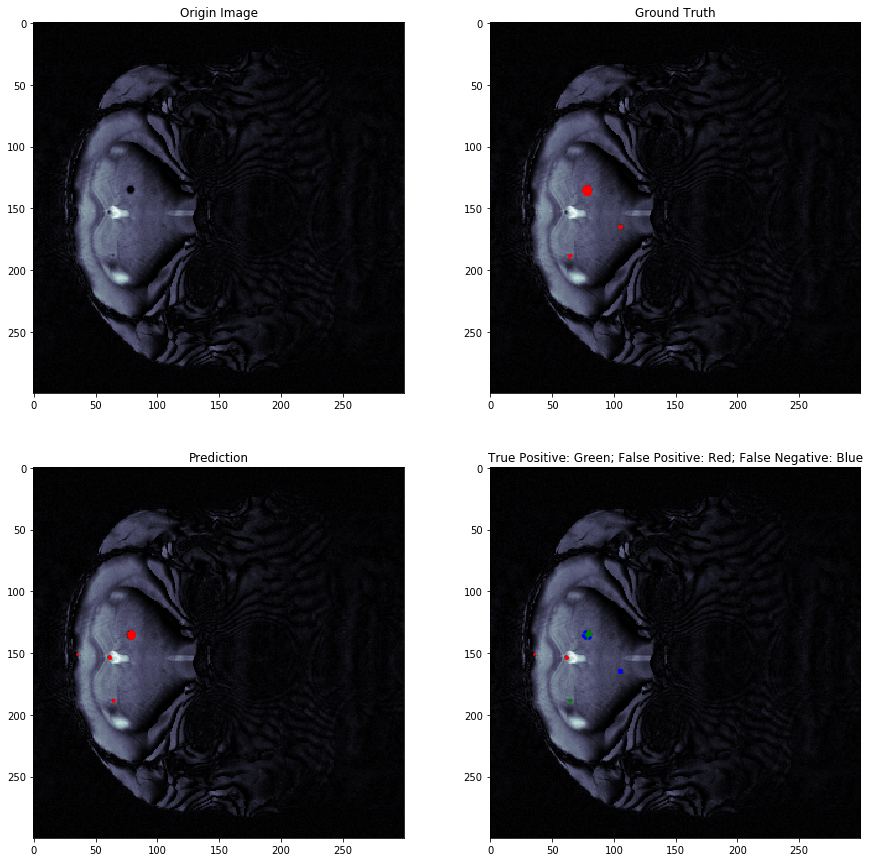

In [19]:
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.title('Origin Image')
plt.imshow(img, cmap='bone')
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(img, cmap='bone')
plt.scatter(np.where(gt == 1)[1], np.where(gt == 1)[0], c='Red', s=3)
plt.subplot(223)
plt.title('Prediction')
plt.imshow(img, cmap='bone')
plt.scatter(np.where(p == 1)[1], np.where(p == 1)[0], c='Red', s=3)
plt.subplot(224)
plt.title('True Positive: Green; False Positive: Red; False Negative: Blue')
plt.imshow(img, cmap='bone')
plt.scatter(np.where(tp == 1)[1], np.where(tp == 1)[0], c='Green', s=3)
plt.scatter(np.where(fp == 1)[1], np.where(fp == 1)[0], c='Red', s=3)
plt.scatter(np.where(fn == 1)[1], np.where(fn == 1)[0], c='Blue', s=3)